# Line plots
This Python Jupyter notebook plots escape map line plots.

## Imports and configuration
Import Python modules:

In [9]:
import os

import Bio.SeqIO

import dmslogo
import dmslogo.colorschemes

from IPython.display import display, HTML

import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt

import math
import natsort
import numpy as np

import pandas as pd
from plotnine import *

import yaml

Get configuration:

In [10]:
with open('../config.yaml') as f:
    config = yaml.safe_load(f)
    
with open('../data/line_plots_config.yaml') as f:
    line_plot_config = yaml.safe_load(f)
    
results_dir = '../results/line_plots'
os.makedirs(results_dir, exist_ok=True)

## Read escape fractions
Read the escape fractions, only keeping average of libraries:

In [11]:
mut_metric = config['mut_metric']
site_metric = config['site_metric']

escape_fracs = (pd.read_csv(os.path.join('../', config['escape_fracs']))
                .query('library == "average"')
                .drop(columns=['site', 'selection', 'library'])
                .rename(columns={'label_site': 'site'})
                )
print('First few lines of escape-fraction data frame:')
display(HTML(escape_fracs.head().to_html(index=False)))

First few lines of escape-fraction data frame:


condition,site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
12C_d152_80,331,N,A,E,331,0.002020,0.001326,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,331,N,D,E,331,0.005616,0.000537,0.04926,0.0478,0.003079,0.002988,1
12C_d152_80,331,N,E,E,331,0.002535,0.000482,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,331,N,F,E,331,0.003032,0.005816,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,331,N,G,E,331,0.003113,0.001273,0.04926,0.0478,0.003079,0.002988,2


Some sites / mutations are totally missing in the `escape_fracs` data frame.
For plotting with `dmslogo`, we need to pad these missing sites to be zero:

In [12]:
# make "padding" data frame covering all conditions, sites, and mutations
first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()
mutations = escape_fracs['mutation'].unique()
pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': site,
                                  'mutation': mutations})
                    for condition in escape_fracs['condition'].unique()
                    for site in range(first_site, last_site + 1)])

# need to read in wildtype and map site to wildtype
wt_prot = str(Bio.SeqIO.read(os.path.join('../', config['wildtype_sequence']), 'fasta').seq.translate())
assert len(wt_prot) == last_site - first_site + 1
site_to_wt = {site: wt_prot[site - first_site] for site in range(first_site, last_site + 1)}
for site, wt in escape_fracs.set_index('site')['wildtype'].to_dict().items():
    if wt != site_to_wt[site]:
        raise ValueError(site, wt, site_to_wt[site])

# pad escape fracs data frame
escape_fracs_padded = (
    escape_fracs
    [['condition', 'site', 'mutation', site_metric, mut_metric]]
    .merge(pad_df, how='outer')
    .fillna(0)
    .assign(wildtype=lambda x: x['site'].map(site_to_wt),
            wt_site=lambda x: x['wildtype'] + x['site'].astype(str))
    .assign(**{site_metric: lambda x: x.groupby(['condition', 'site'])[site_metric].transform('max')})
    )

Here's what I'm thinking:
For `name, specs` in `line_plot_config`, make facet plot using `plts.subplots()`. 
See [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html).

Other things to specify in config file:
* which sites to highlight in line plot (show_col) (also ask Jesse if this can be made full-height like in Adam's Immunity paper rather than just at bottom of x-axis)
* color to highlight with (show_color): `highlight_color`, default='#E69F00'

Things that are still not working:
* find a way to share x-axes
* single x- and y-axis title for the whole plot

## Plot logos with overlays
Loop over all of the sets of line plots to draw:


Drawing faceted line plots for convalescent (day 100-150):
Highlight sites: [456, 484]


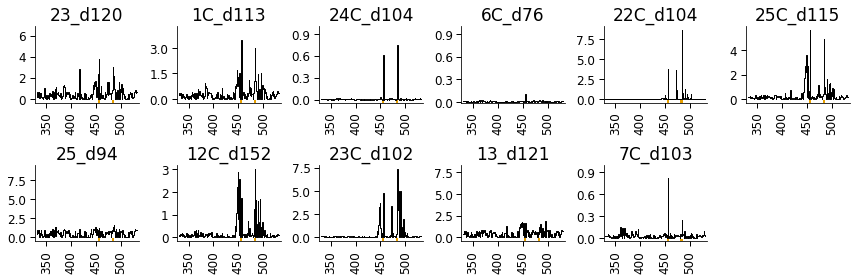

Saving to ./../results/line_plots/convalescent (day 100-150)_line_plots.pdf

Drawing faceted line plots for convalescent (day 15-60):
Highlight sites: [456, 484]


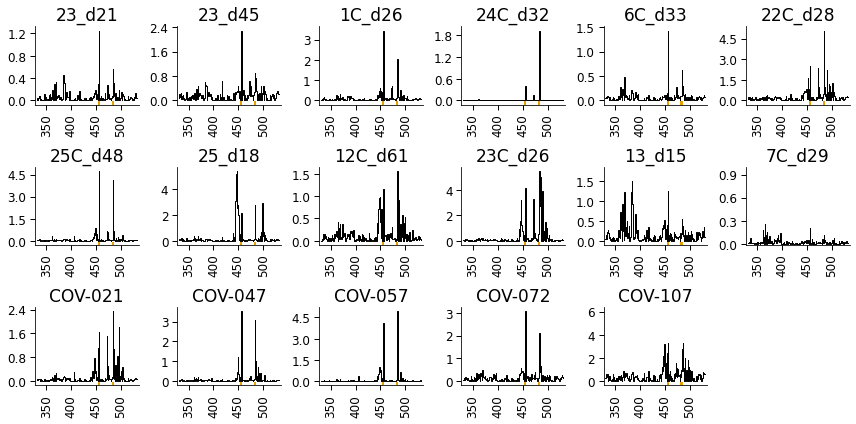

Saving to ./../results/line_plots/convalescent (day 15-60)_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (day 36):
Highlight sites: [456, 484]


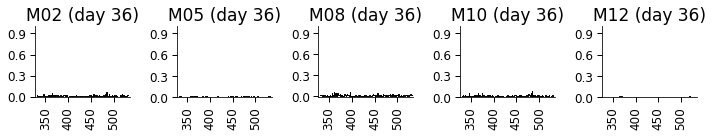

Saving to ./../results/line_plots/mRNA-1273 (day 36)_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (day 119):
Highlight sites: [456, 484]


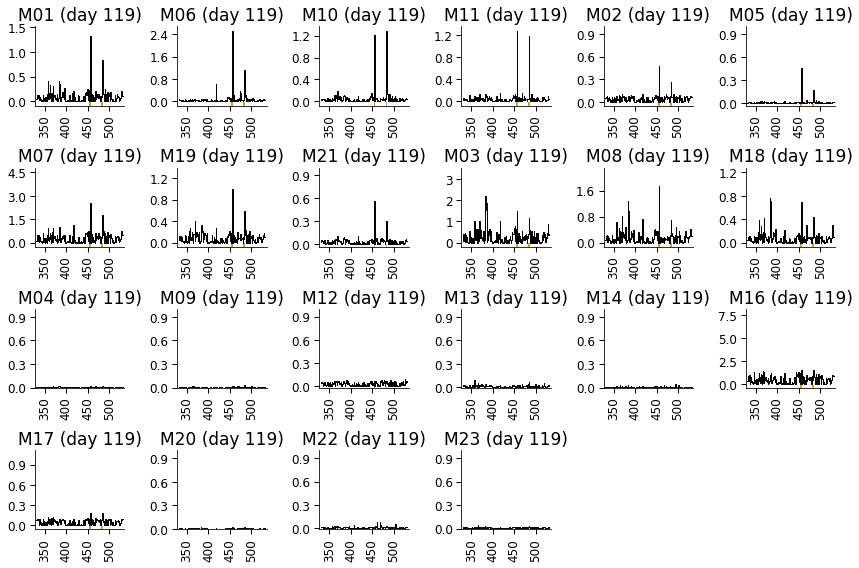

Saving to ./../results/line_plots/mRNA-1273 (day 119)_line_plots.pdf

Drawing faceted line plots for convalescent (day 100-150):
Highlight sites: [456, 484]


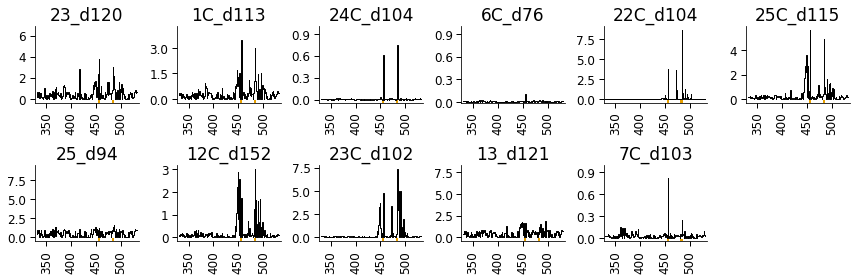

Saving to ./../results/line_plots/convalescent (day 100-150)_line_plots.pdf

Drawing faceted line plots for convalescent (day 15-60):
Highlight sites: [456, 484]


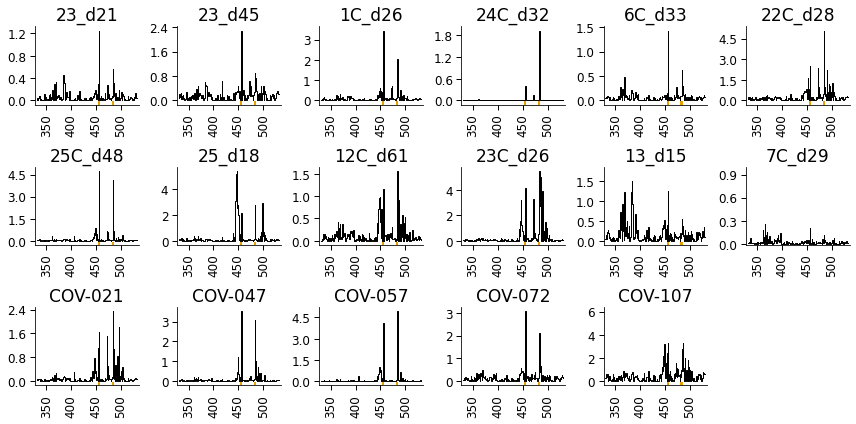

Saving to ./../results/line_plots/convalescent (day 15-60)_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (day 36):
Highlight sites: [456, 484]


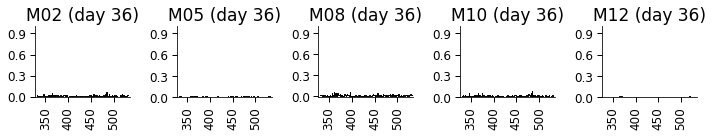

Saving to ./../results/line_plots/mRNA-1273 (day 36)_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (day 119):
Highlight sites: [456, 484]


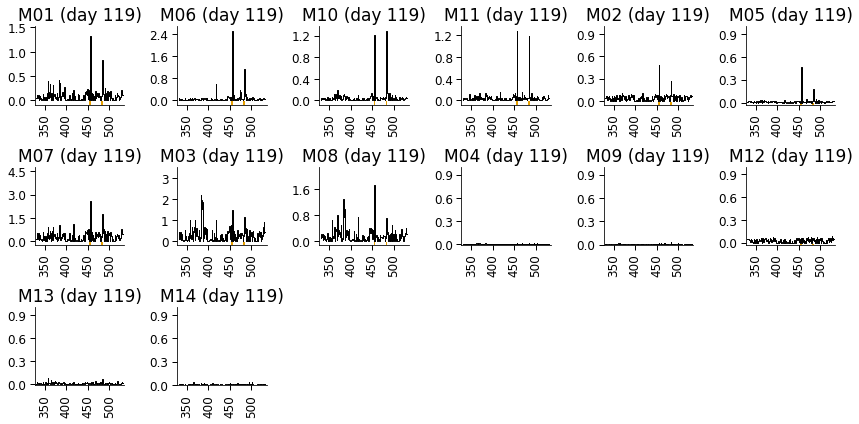

Saving to ./../results/line_plots/mRNA-1273 (day 119)_line_plots.pdf

Drawing faceted line plots for convalescent_validated:
Highlight sites: [456, 484]


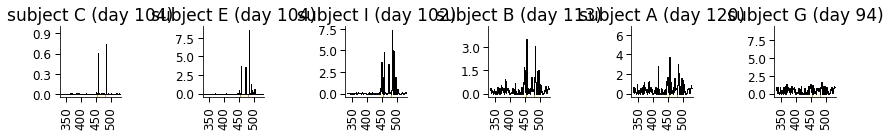

Saving to ./../results/line_plots/convalescent_validated_line_plots.pdf

Drawing faceted line plots for Moderna_validated:
Highlight sites: [456, 484]


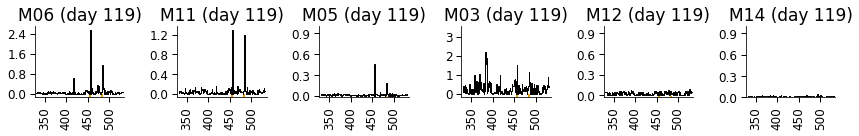

Saving to ./../results/line_plots/Moderna_validated_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (100ug dose):
Highlight sites: [456, 484]


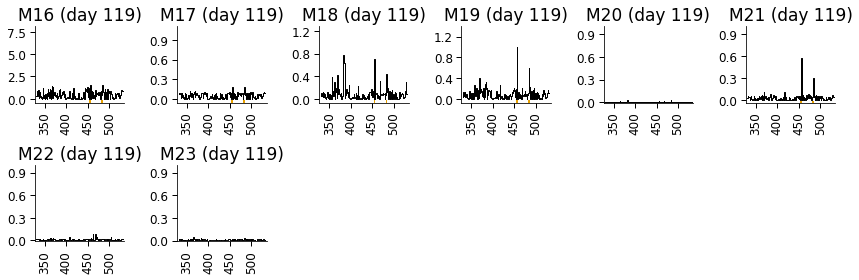

Saving to ./../results/line_plots/mRNA-1273 (100ug dose)_line_plots.pdf

Drawing faceted line plots for mRNA-1273 (250ug dose):
Highlight sites: [456, 484]


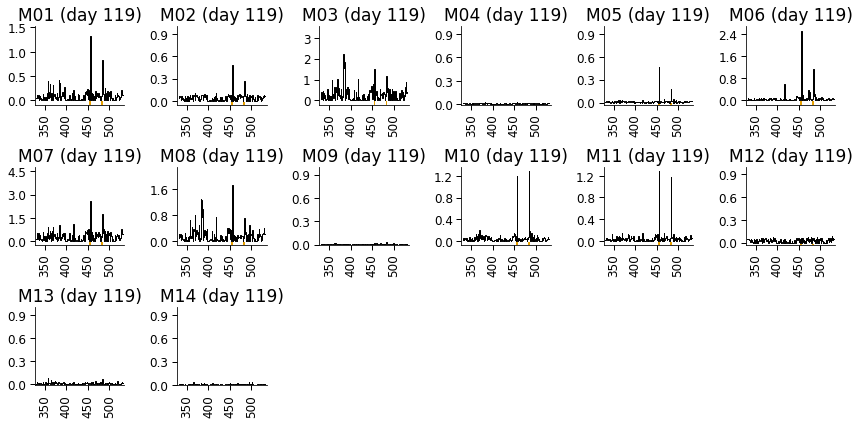

Saving to ./../results/line_plots/mRNA-1273 (250ug dose)_line_plots.pdf


In [13]:
 # get relevant data frame with escape fractions
for supergroup, subgroup in line_plot_config.items():
    for name, specs in subgroup.items():
        print(f"\nDrawing faceted line plots for {name}:")

        # get any additional logo plot arguments
        if 'dmslogo_draw_line_kwargs' in specs:
            dmslogo_draw_line_kwargs = specs['dmslogo_draw_line_kwargs']

        # sites to highlight:
        highlight_sites = specs['highlight_sites'] if 'highlight_sites' in specs else []
        print(f'Highlight sites: {highlight_sites}')

        # get data frame with just the conditions we want to plot, also re-naming them
        conditions_to_plot = list(specs['conditions'].keys())
        assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
        assert set(conditions_to_plot).issubset(set(escape_fracs_padded['condition']))

        # the default ncol = 6, can be overriden by specs
        max_ncol=specs['ncol']if 'ncol' in specs else 6
        ncol = min(max_ncol, len(conditions_to_plot))
        nrow = math.ceil(len(conditions_to_plot) / ncol)

        fig = plt.figure(figsize=(ncol*2, nrow*2))
        #fig, axs = plt.subplots(nrow, ncol)

        # then iterate through the conditions in conditions_to_plot and make line plot for each one
        for i, condition in zip(range(len(conditions_to_plot)), list(specs['conditions'].values())):
            df = (escape_fracs_padded
                  .query('condition in @conditions_to_plot')
                  .assign(condition=lambda x: x['condition'].map(specs['conditions']))
                  .query('condition==@condition')
                  .assign(to_show=lambda x: x['site'].isin(highlight_sites))
                  )

            # get y-axis limits, see here: https://jbloomlab.github.io/dmslogo/set_ylims.html
            if 'escape_profile_ymax' in specs:  # specific y-max set for this plot
                escape_profile_ymax_quantile = specs['escape_profile_ymax']['quantile']
                escape_profile_ymax_frac = specs['escape_profile_ymax']['frac']
                if 'min_ymax' in specs['escape_profile_ymax']:
                    escape_profile_min_ymax = specs['escape_profile_ymax']['min_ymax']
                else:
                    escape_profile_min_ymax = None

            else:  # use default in config
                escape_profile_ymax_quantile = config['escape_profile_ymax']['quantile']
                escape_profile_ymax_frac = config['escape_profile_ymax']['frac']
                if 'min_ymax' in config['escape_profile_ymax']:
                    escape_profile_min_ymax = config['escape_profile_ymax']['min_ymax']
                else:
                    escape_profile_min_ymax = None

            ylim_setter = dmslogo.utils.AxLimSetter(max_from_quantile=(escape_profile_ymax_quantile,
                                                                       escape_profile_ymax_frac),
                                                    datalim_pad=0.06,
                                                    min_upperlim=escape_profile_min_ymax)

            ax = fig.add_subplot(nrow, ncol, i+1)

            ax = dmslogo.line.draw_line(
                data=df,
                x_col='site',
                height_col=site_metric,
                show_col='to_show',
                show_color=specs['highlight_color'] if 'highlight_color' in specs else '#E69F00',
                xlabel='',
                ylabel='',
                title=condition,
                ylim_setter=ylim_setter,
                ax=ax,
                **dmslogo_draw_line_kwargs)

        fig.tight_layout()
        plt.show(fig)

        plotfile = f'./{results_dir}/{name}_line_plots.pdf'
        print(f"Saving to {plotfile}")
        fig.savefig(plotfile, bbox_inches='tight')

        plt.close()

## Make group-averaged line plots

* First, loop through each entry in config and get `conditions` dictionary
* make temporary dataframe from dictionary (`orient=index`)
* Assign `name` column for each group
* Concatenate the dictionaries together
* Merge with `escape_fracs_padded`
* Then basically paste in Jesse's code

In [14]:
print(f"Reading escape fractions from {config['escape_fracs']}")

escape_fracs = (
    pd.read_csv(os.path.join('..',config['escape_fracs']))
    .query('library == "average"')
    .assign(site=lambda x: x['label_site'])
    .groupby(['selection', 'site'])
    .aggregate(total_escape=pd.NamedAgg(config['mut_metric'], 'sum'),
               max_escape=pd.NamedAgg(config['mut_metric'], 'max')
               )
    .reset_index()
    .rename(columns={'selection':'condition'})
)

first_site = escape_fracs['site'].min()
last_site = escape_fracs['site'].max()

pad_df = pd.concat([pd.DataFrame({'condition': condition,
                                  'site': site}, index=[0])
                    for condition in escape_fracs['condition'].unique()
                    for site in range(first_site, last_site + 1)])
                    
                    
escape_fracs = (escape_fracs
                .merge(pad_df, how='outer', on=['condition', 'site'])
                .fillna(0)
               )

escape_fracs.head()

escape_fracs.query('site==416')

Reading escape fractions from results/escape_scores/escape_fracs.csv


,condition,site,total_escape,max_escape
14094,12C_d152_80,416,0.0,0.0
14121,12C_d61_160,416,0.0,0.0
14148,13_d121_1250,416,0.0,0.0
14175,13_d15_200,416,0.0,0.0
14202,1C_d113_200,416,0.0,0.0
...,...,...,...,...
16154,M22-day-119_200,416,0.0,0.0
16181,M23-day-119_200,416,0.0,0.0
16208,REGN10933+REGN10987_400,416,0.0,0.0
16235,REGN10933_400,416,0.0,0.0


   xmin  xmax antibody_class    label                group_name
5   382   387        class_4  383-386  convalescent (day 15-60)
6   482   487        class_2  483-486  convalescent (day 15-60)
Saving to ../results/line_plots/compare_vax_conv_grouped_lineplots_total.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label                group_name
5   382   387        class_4  383-386  convalescent (day 15-60)
6   482   487        class_2  483-486  convalescent (day 15-60)
Saving to ../results/line_plots/compare_vax_conv_grouped_lineplots_max.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label                group_name
5   382   387        class_4  383-386  convalescent (day 15-60)
6   482   487        class_2  483-486  convalescent (day 15-60)
Saving to ../results/line_plots/compare_vax_conv_250ug_grouped_lineplots_total.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label                group_name
5   382   387        class_4  383-386  convalescent (day 15-60)
6   482   487        class_2  483-486  convalescent (day 15-60)
Saving to ../results/line_plots/compare_vax_conv_250ug_grouped_lineplots_max.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label         group_name
5   382   387        class_4  383-386  Moderna_validated
6   482   487        class_2  483-486  Moderna_validated
Saving to ../results/line_plots/validations_grouped_lineplots_total.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label         group_name
5   382   387        class_4  383-386  Moderna_validated
6   482   487        class_2  483-486  Moderna_validated
Saving to ../results/line_plots/validations_grouped_lineplots_max.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label              group_name
0   382   387        class_4  383-386  mRNA-1273 (100ug dose)
1   482   487        class_2  483-486  mRNA-1273 (100ug dose)
Saving to ../results/line_plots/100vs250ug_day119_grouped_lineplots_total.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


   xmin  xmax antibody_class    label              group_name
0   382   387        class_4  383-386  mRNA-1273 (100ug dose)
1   482   487        class_2  483-486  mRNA-1273 (100ug dose)
Saving to ../results/line_plots/100vs250ug_day119_grouped_lineplots_max.pdf


/fh/fast/bloom_j/software/miniconda3/envs/SARS-CoV-2-RBD_MAP/lib/python3.7/site-packages/plotnine/scales/scale_alpha.py:70: PlotnineWarning: Using alpha for a discrete variable is not advised.


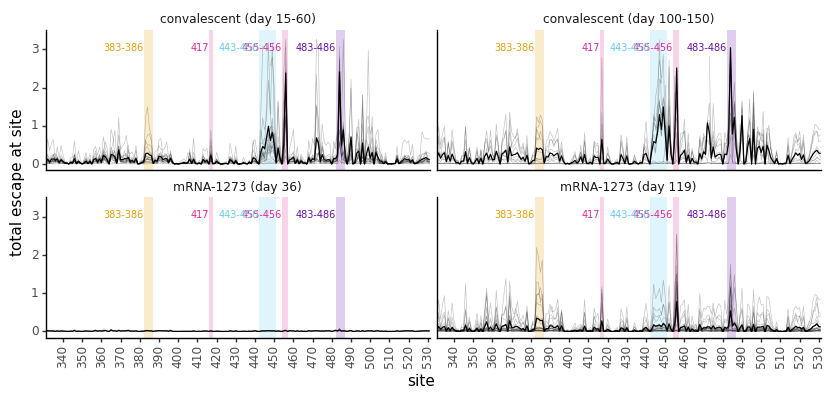

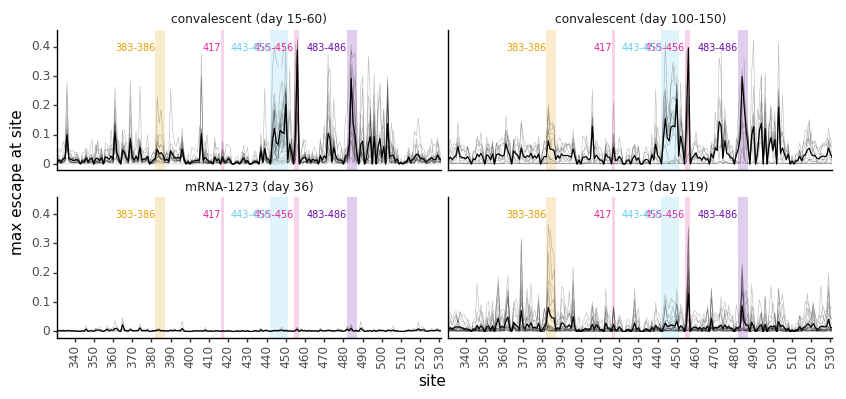

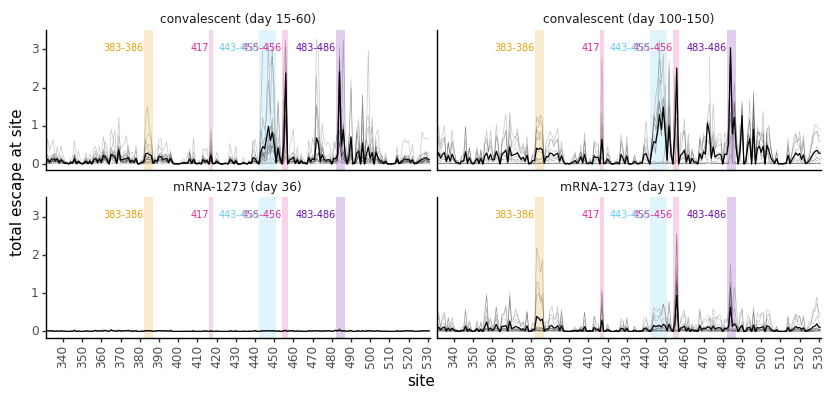

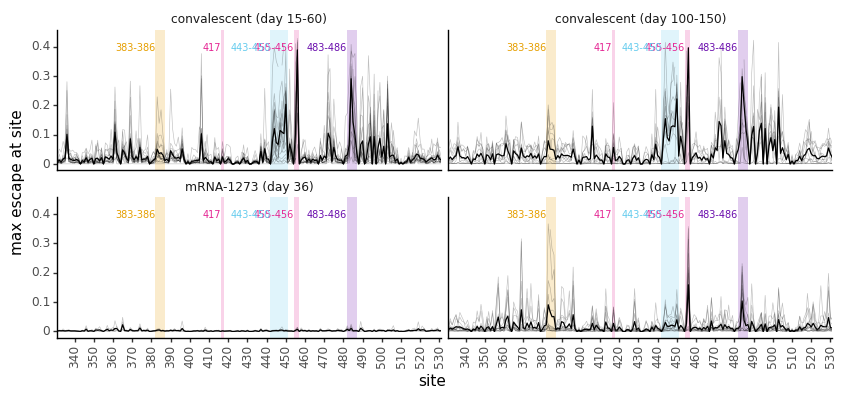

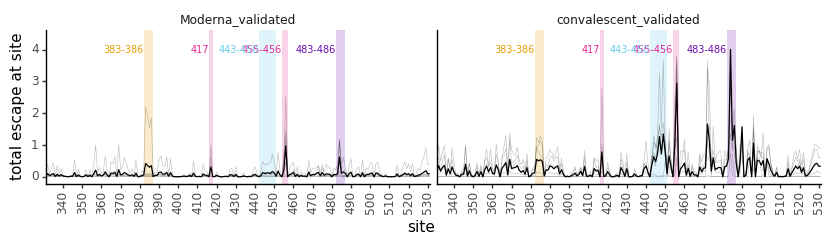

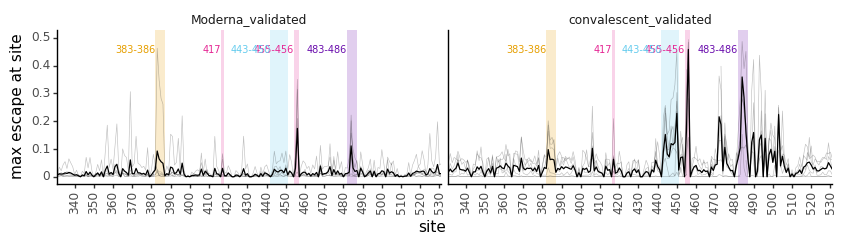

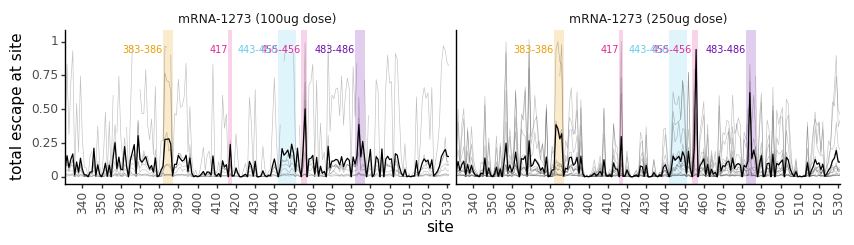

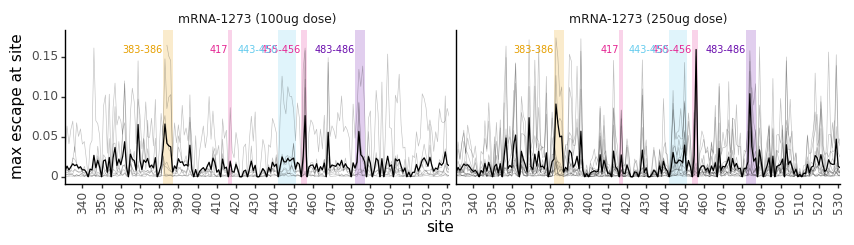

In [15]:
for supergroup, subgroup in line_plot_config.items():

    for metric in ['total', 'max']:
        lineplot_df = pd.DataFrame()
        annotation_df = pd.DataFrame()

        for name, specs in subgroup.items():

            # get data frame with just the conditions we want to plot, also re-naming them
            conditions_to_plot = list(specs['conditions'].keys())
            assert len(conditions_to_plot) == len(set(specs['conditions'].values()))
            assert set(conditions_to_plot).issubset(set(escape_fracs_padded['condition']))

            # then iterate through the conditions in conditions_to_plot and make line plot for each one
            df = (escape_fracs
                  .query('condition in @conditions_to_plot')
                  .assign(condition=lambda x: x['condition'].map(specs['conditions']),
                          group_name=name,
                         )
                  )
            lineplot_df = (pd.concat([lineplot_df,df], axis=0, ignore_index=True))

            label_df = (pd.DataFrame({'xmin': [382,482,454,442,416],
                                     'xmax': [387,487,457,451,418],
                                     'antibody_class': ['class_4', 'class_2', 'class_1', 'class_3', 'class_1'],
                                     'label': ['383-386','483-486','455-456','443-450','417'],
                                    }
                                   )
                        .assign(group_name=name,)
                       )
            annotation_df = pd.concat([annotation_df, label_df], axis=0, ignore_index=True)

        lineplot_df = (lineplot_df
            [['condition', 'site', metric+'_escape', 'group_name']]
            .rename(columns={metric+'_escape': metric+' escape at site'})
            .drop_duplicates()
            )

        # add mean in each group
        df_with_mean = (
            lineplot_df
            .append(lineplot_df.groupby(['group_name', 'site'], as_index=False)
                          .aggregate('mean')
                          .assign(condition='mean')
                    )
            .assign(is_mean=lambda x: x['condition'] == 'mean')
            )

        df_with_mean.head()

        annotation_df = (annotation_df
                         .assign(group_name=lambda x: pd.Categorical(x['group_name'], ordered=True,
                                                                   categories=natsort.natsorted(x['group_name'].unique()),)) 
                         .sort_values('group_name', key=lambda x: np.argsort(natsort.index_natsorted(x)))
                        )
        print(annotation_df.head(2))

        # space breaks every ? sites
        site_break_freq = 10
        def get_site_breaks(tup):
            start = int(math.ceil(tup[0] / site_break_freq)) * site_break_freq
            end = int(math.floor(tup[1] / site_break_freq)) * site_break_freq
            return list(range(start, end + 1, site_break_freq))

        # make plot
        p = (ggplot(df_with_mean
                    .assign(group_name=lambda x: pd.Categorical(x['group_name'], ordered=True,
                                                                   categories=natsort.natsorted(x['group_name'].unique()),)) 
                    .sort_values('group_name', key=lambda x: np.argsort(natsort.index_natsorted(x)))
                   ) +
             aes('site', metric+' escape at site',
                 group='condition',
                 alpha='is_mean', size='is_mean') +

             geom_rect(data=annotation_df.assign(is_mean=False),
                       mapping=aes(xmin='xmin',
                                   xmax='xmax',
                                   ymin=-np.inf,
                                   ymax=np.inf,
                                   fill='antibody_class',
                                  ),
                       alpha=0.2,
                       inherit_aes=False,
                      ) +

             geom_line() +

             geom_text(data=annotation_df,
                       mapping=aes(label='label', 
                                   x='xmin', 
                                   y=df_with_mean.query('is_mean')[metric+' escape at site'].max(), 
                                   color='antibody_class'),
                       size=7,
                       ha='right',
                       inherit_aes=False,
                      ) +
             facet_wrap('~ group_name', ncol=2) +
             theme_classic() +
             theme(figure_size=(10, 1 * df_with_mean['group_name'].nunique()),
                   axis_text_x=element_text(rotation=90, hjust=0.5),
                   strip_background=element_blank(),
                   ) +
             scale_x_continuous(expand=(0, 0), breaks=get_site_breaks) +
             scale_y_continuous(limits=(None, (df_with_mean.query('is_mean')[metric+' escape at site'].max()*1.1))) +
             scale_alpha_discrete(range=(0.25, 1)) +  # transparency of individual and mean lines
             scale_size_manual(values=(0.25, 0.5)) +  # size of individual and mean lines
             scale_color_manual(values=['#e52794', '#6a0dad', '#66ccee', '#E69F00']) +
             scale_fill_manual(values=['#e52794', '#6a0dad', '#66ccee', '#E69F00']) +
             guides(alpha=False, size=False, color=False, fill=False)
             )

        plotfile = f'{results_dir}/{supergroup}_grouped_lineplots_{metric}.pdf'
        print(f"Saving to {plotfile}")
        p.save(plotfile, verbose=False)

        _ = p.draw()